In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
####################################################################################################

import os

import numpy as np
import pylab as pb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import SchemDraw as schem

####################################################################################################
import PySpice
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

####################################################################################################


from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *
#from PySpice.Physics.SemiConductor import ShockleyDiode
from PySpice.Spice.Netlist import SubCircuitFactory

os.environ['PySpiceLibraryPath'] = '~/Projects/ROIC/src/PySpice/examples/libraries'

####################################################################################################

libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)
####################################################################################################

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:908: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:908: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


2018-11-29 14:39:08,915 - PySpice.Doc.ExampleTools.find_libraries - INFO - SPICE library path is ~/Projects/ROIC/src/PySpice/examples/libraries


In [2]:
from math import pi
#cgs units
cm = 1.0
m = 100.0
mum = 1e-6*m
nm = 1e-9*m
g = 1.0
kg = 1000.0*g

s = 1.0
ms = 1e-3*s
ns = 1e-9*s
mus = 1e-6*s

Hertz = Hz = 1.0/s

erg = g*cm**2/s**2
Joule = kg*m**2/s**2

Watt = Joule/s
mW = 1e-3*Watt
nW = 1e-9*Watt

Coulomb = 1.0
Ampere = Coulomb/s
mA = 1e-3*Ampere
nA = 1e-9*Ampere
Kelvin = 1.0

eps0 = 8.854187817620e-12*Ampere**2*s**4/kg/m**3
h_planck = 6.62606885e-27*erg*s
hbar_planck = h_planck/2.0/pi
q_e = 1.6021766208e-19*Coulomb
k_b = 1.38064852e-16*erg/Kelvin

eV =q_e*Joule/Coulomb
Volt = Joule/Coulomb
mV = 1e-3*Volt

Ohm = Volt/Ampere
kOhm = 1e3*Ohm
MOhm = 1e6*Ohm 

Farad = Coulomb/Volt
uF = 1e-6*Farad
nF  = 1e-9*Farad
pF = 1e-12*Farad

In [3]:
PySpice.__file__

'/home/chaffra/Projects/ROIC/src/PySpice/PySpice/__init__.py'

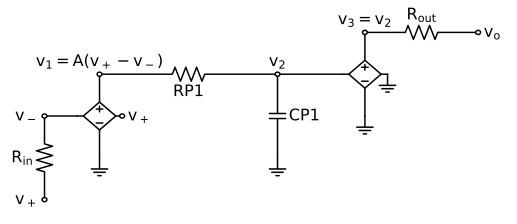

In [3]:
class BasicOperationalAmplifier(SubCircuitFactory):

    __name__ = 'BasicOperationalAmplifier'
    __nodes__ = ('v_plus', 'v_minus', 'output')
    __pins__ = ('v+', 'v-', 'out')


    def __init__(self, gnd_node=None):

        super().__init__()
        
        if gnd_node is None:
            gnd_node = self.gnd

        # Input impedance
        RIN = self.R('input', 'v_plus', 'v_minus', 10@u_MΩ,
               schematic_kwargs={'schematic': schem.elements.RES,
                              'label': r'$R_{in}$', 'd': 'up',
                              'show_start': True, 'start_label': {'lftlabel': r'$v_+$'},
                              'show_end': True, 'end_label': {'lftlabel': r'$v_-$'},
                             }
              )
        self.RIN = RIN
        #self._schematic.add(schem.elements.RES,label=r'$R_in$')

        # dc gain=100k and pole1=100hz
        # unity gain = dcgain x pole1 = 10MHZ
        self.schematic.add(schem.elements.LINE, d ='right', l=1.0)
        vcvs_in = self.VCVS('gain', 1, gnd_node, 'v_plus', 'v_minus', voltage_gain=kilo(100),
                 schematic_kwargs={'schematic': schem.elements.SOURCE_CONT_V,
                                   'anchor':'in1',#'d':'right',
                                   'show_end': True, 'end_label': {'toplabel': r'$v_1 = A(v_+ - v_-)$'},
                              #'rgtlabel': r'$A(v_+ - v_-)$',
                                   #'l': RIN.schematic_element.dy,
                             })
        self.vcvs_in = vcvs_in
        self.schematic.add(schem.elements.GND, xy=vcvs_in.schematic_element.start)
        self.schematic.add(schem.elements.DOT_OPEN, xy=vcvs_in.schematic_element.in2, rgtlabel=r'$v_+$')
    
        #self.schematic.add(schem.elements.LINE, xy=vcvs_in.schematic_element.end, d='right', l=1.5)
        RP1 = self.R('P1', 1, 2, 1@u_kΩ,
              schematic_kwargs={'schematic': schem.elements.RES,
                                   'd':'right',
                                'xy': vcvs_in.schematic_element.end,
                              'botlabel': r'$RP1$',
                                'l':5.5
                             })
        CP1 = self.C('P1', 2, gnd_node, 1.5915@u_uF, 
              schematic_kwargs={'schematic': schem.elements.CAP,
                                   'd':'down',
                              'botlabel': r'$CP1$',
                              'show_start': True, 'start_label': {'toplabel': r'$v_2$'},
                             })
        self.schematic.add(schem.elements.GND, xy=CP1.schematic_element.end)

        # Output buffer and resistance
        self.schematic.add(schem.elements.LINE, xy=CP1.schematic_element.start, d='right', l=2.0)
        vcvs_out = self.VCVS('buffer', 3, gnd_node, 2, gnd_node, 1,
                 schematic_kwargs={'schematic': schem.elements.SOURCE_CONT_V,
                                   'anchor':'in1',#'d':'right',
                                   'show_end': True, 'end_label': {'toplabel': r'$v_3 = v_2$'}}
                                )
        self.vcvs_out = vcvs_out
        self.schematic.add(schem.elements.GND, xy=vcvs_out.schematic_element.start)
        self.schematic.add(schem.elements.GND, xy=vcvs_out.schematic_element.in2)
        
        
        ROUT = self.R('out', 3, 'output', 10@u_Ω,
               schematic_kwargs={'schematic': schem.elements.RES,
                              'label': r'$R_{out}$', 'd': 'right',
                              'show_end': True, 'end_label': {'rgtlabel': r'$v_{o}$'},
                              'l': 3.5
                             }
              )
        self.ROUT = ROUT
        
opamp = BasicOperationalAmplifier()
opamp.schematic.draw()

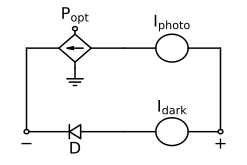

In [4]:
class BasicPhotoDiode(SubCircuitFactory):

    __name__ = 'BasicPhotoDiode'
    __nodes__ = ('anode', 'cathode', 'popt')
    __pins__ = ('anode', 'cathode', 'popt')


    def __init__(self, gnd_node=None):

        super().__init__()
        
        if gnd_node is None:
            gnd_node = self.gnd
            

        diode_model = self.model('Diode', 'D', Is=1.0*nA/Ampere, Rs=10.0, N=1.0,
                                  VJ=1.0, W=20*mum/m, L=20*mum/m,
                                 )
        
        DD = self.D('sensor', 1, 'cathode', model='Diode',
            schematic_kwargs={'schematic': schem.elements.DIODE,
                              'd': 'right',
                              'show_end': True, 'end_label': {'botlabel': r'$-$'},
                              'flip': True, 'reverse':True,
                              'botlabel': r'$D$'
                             }
        )
        self.DD = DD
        
        ID_PROBE = self.V('idark', 'anode', 1, 0.0@u_V,
               schematic_kwargs={
                   'schematic': schem.elements.SOURCE,
                   'xy': DD.schematic_element.start,
                   'show_end': True, 'end_label': {'botlabel': r'$+$'},
                   'd':'right', 'label':r'$I_{dark}$',}
        )
        self.ID_PROBE = ID_PROBE
        
        self.schematic.add(schem.elements.LINE, d='up', xy=DD.schematic_element.end)
        
        IPH_SOURCE = self.VCCS('photo', 'cathode', 2, 'popt', gnd_node, transconductance=1.0@u_A/Watt,
                   schematic_kwargs={'schematic': schem.elements.SOURCE_CONT_I,
                                     #'xy': IPH_PROBE.schematic_element.end,
                                    'd':'right'}
                  )
        self.IPH_SOURCE = IPH_SOURCE
        
        IPH_PROBE = self.V('iphoto','anode', 2,  0.0@u_V,
               schematic_kwargs={
                   'schematic': schem.elements.SOURCE,
                   #'xy': DD.schematic_element.end,
                   'd':'right', 'label':r'$I_{photo}$',}
        )
        self.IPH_PROBE = IPH_PROBE
        
        
        self.schematic.add(schem.elements.LINE, d='down')
        
        #POPT = self.V('popt', 'popt', gnd_node, 0e-9*Watt,
        #    schematic_kwargs={'d':'up', 'show_end': False,
        #                      'reverse': True,
        #                     'xy': IPH_SOURCE.schematic_element.in1,
        #                     'toplabel':r'$P_{opt}$'}
        #)
        #self.POPT = POPT
        
        self.schematic.add(schem.elements.DOT_OPEN, xy=IPH_SOURCE.schematic_element.in1, flip=False,
                          toplabel=r'$P_{opt}$')
        self.schematic.add(schem.elements.GND, xy=IPH_SOURCE.schematic_element.in2, flip=False)
        
        #circuit.schematic.add(schem.elements.LINE, xy=DD.schematic_element.start, d ='down', l=1.5)
#CD = circuit.C('d', 'anode', 'Vd', 1@u_uF,
#               schematic_kwargs={'schematic': schem.elements.CAP, 'botlabel': r'$C_d$',
#                              'd': 'left', 'l': DD.schematic_element.dx}
#              )
#circuit.schematic.add(schem.elements.LINE, xy=CD.schematic_element.end, to=DD.schematic_element.end)

        
photo_diode = BasicPhotoDiode()
photo_diode.schematic.draw()

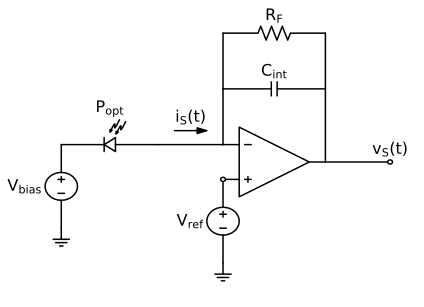

In [30]:
#r# For this purpose, we use the common high-speed diode 1N4148.  The diode is driven by a variable
#r# voltage source through a limiting current resistance.

#f# circuit_macros('diode-characteristic-curve-circuit.m4')

circuit = Circuit('Capacitive Transimpedance Amplifier (CTIA) readout')

#circuit.include(spice_library['1N4148'])

VBIAS =circuit.V('bias', 'cathode', circuit.gnd, 0.0@u_V,
            schematic_kwargs={'d':'up', 'show_end': False,
                             'toplabel':r'$V_{bias}$'}
            )
circuit.schematic.add(schem.elements.GND, xy=VBIAS.schematic_element.start)


photo_diode = BasicPhotoDiode(circuit.gnd)
circuit.subcircuit(photo_diode)
XPD = circuit.X('PD', 'BasicPhotodiode','opamp_minus', 'cathode', 'popt',
         schematic_kwargs={'schematic': schem.elements.PHOTODIODE,
                              'xy':VBIAS.schematic_element.end,
                              'd': 'right',
                           #'show_end': True, 'end_label': {'lftlabel': r'$V_d$'},
                              'flip': False, 'reverse':True,
                              'toplabel': r'$P_{opt}$'
                        })

POPT = circuit.V('popt', 'popt', circuit.gnd, 0e-9*Watt,
            schematic_kwargs={'schematic': {},
                #'d':'up', 'show_end': False,
                #                  'reverse': True,
                #                 #'xy': IPH_SOURCE.schematic_element.in1,
                #                 'toplabel':r'$P_{opt}$'
                }
)

opamp = BasicOperationalAmplifier(circuit.gnd)
circuit.subcircuit(opamp)
seg = circuit.schematic.add(schem.elements.LINE, xy=XPD.schematic_element.start, d ='right', l=2.0)
circuit.schematic.labelI(seg, arrowlen=1.0, reverse=False, arrowofst=0.5,
                        label=r'$i_S(t)$', top=True)

XA = circuit.X('A', 'BasicOperationalAmplifier', 'opamp_plus', 'opamp_minus', 'Aout',
         schematic_kwargs={'schematic': schem.elements.OPAMP, 'anchor': 'in1', 
                              'd': 'right', 'flip':False,
                           #'xy': CD.schematic_element.start
                          })
circuit.schematic.add(schem.elements.DOT_OPEN, xy=XA.schematic_element.in2)

VREF =circuit.V('ref', 'opamp_plus', circuit.gnd, 0.0@u_mV,
            schematic_kwargs={'d':'down', 'show_end': False,
                              'xy': XA.schematic_element.in2,
                              'reverse': True,
                              'toplabel': r'$V_{ref}$'
                             }
            )

circuit.schematic.add(schem.elements.GND)

circuit.schematic.add(schem.elements.LINE, xy=XA.schematic_element.in1, d ='up', l=2.0)
CINT = circuit.C('int', 'opamp_minus', 'Aout', 1@u_nF,
               schematic_kwargs={'schematic': schem.elements.CAP, 'toplabel': r'$C_{int}$',
                              'd': 'right', 'l': XA.schematic_element.dx}
              )
circuit.schematic.add(schem.elements.LINE, xy=XA.schematic_element.out, d ='up', 
                      to=CINT.schematic_element.end)


circuit.schematic.add(schem.elements.LINE, xy=CINT.schematic_element.start, d ='up', l=2.0)
RF = circuit.R('F', 'opamp_minus', 'Aout', 1.0@u_MOhm,
               schematic_kwargs={'schematic': schem.elements.RES, 'toplabel': r'$R_F$',
                              'd': 'right', 'l': XA.schematic_element.dx}
              )
circuit.schematic.add(schem.elements.LINE, xy=CINT.schematic_element.end, d ='up', l=2.0)

circuit.schematic.add(schem.elements.LINE, xy=XA.schematic_element.out, d ='right', l=2.0)
circuit.schematic.add(schem.elements.DOT_OPEN, label =r'$v_S(t)$')

#RL = circuit.R('L', 'Aout', circuit.gnd, 100@u_MOhm,
#               schematic_kwargs={'schematic': schem.elements.RES, 'botlabel': r'$R_L$',
#                              'd': 'down'}
#              )
#circuit.schematic.add(schem.elements.GND)

circuit.schematic.draw()

2018-11-29 15:09:16,265 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - INFO - Conversion for <ufunc 'subtract'> is UNIT_MATCH
2018-11-29 15:09:16,268 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - INFO - Conversion for <ufunc 'multiply'> is NEW_UNIT
2018-11-29 15:09:16,269 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - INFO - Conversion for <ufunc 'true_divide'> is NEW_UNIT
2018-11-29 15:09:16,271 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - INFO - Conversion for <ufunc 'true_divide'> is NEW_UNIT
2018-11-29 15:09:16,274 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - INFO - Conversion for <ufunc 'true_divide'> is NEW_UNIT
2018-11-29 15:09:16,330 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - INFO - Conversion for <ufunc 'negative'> is NO_CONVERSION
2018-11-29 15:09:16,332 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - INFO - Conversion for <ufunc 'true_divide'> is NEW_UNIT
2018-11-29 15:09:16,335 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - IN

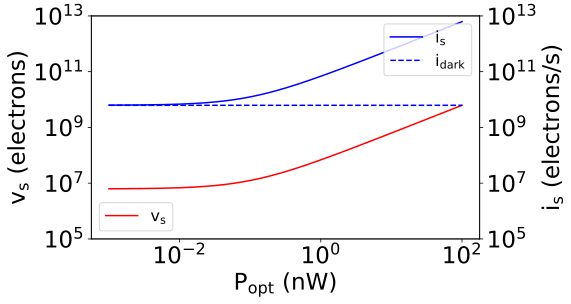

In [32]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
photo_diode.IPH_SOURCE.transconductance = 10@u_A/Watt
#photo_diode.POPT.dc_value = 100e-9*Watt
VREF.dc_value = 0.0@u_V
VBIAS.dc_value = 0.2@u_V
analysis = simulator.dc(Vpopt=slice(0.001*nW, 100*nW, 0.001*nW))
v_s = analysis.aout.convert(U_V)
v_ref = analysis.opamp_plus
N = (v_ref-v_s)*CINT.capacitance.convert(U_F)/Coulomb/q_e
pb.plot(analysis.sweep/nW, N,
        c='r', label=r'$v_s$')
pb.yscale('log')
pb.xscale('log')
pb.xlabel(r'$P_{opt}$ ($nW$)')
pb.ylabel(r'$v_s$ ($electrons$)')
pb.legend(loc=3)
ax1 = pb.gca()
ax1.set_ylim(1e5,1e13)
ax2 = pb.twinx(ax1)
ax2.set_ylim(1e5,1e13)
i_s = -analysis['vbias'].convert(U_A)/Ampere/q_e
i_dark = -analysis['v.xpd.vidark'].convert(U_A)/Ampere/q_e
ax2.plot(analysis.sweep/nW, i_s, c='b', label=r'$i_s$')
ax2.plot(analysis.sweep/nW, i_dark, c='b', ls='--', label=r'$i_{dark}$')
ax2.set_yscale('log')
pb.ylabel(r'$i_s$ ($electrons/s$)')
pb.legend(loc=1)

In [11]:
analysis.nodes.keys()

dict_keys(['aout', 'xa.3', 'xa.2', 'xa.1', 'opamp_plus', 'popt', 'xpd.2', 'opamp_minus', 'xpd.1', 'cathode', 'v-sweep'])

\begin{gather}
v_C(t) \equiv V_{ref}-v_S(t) = V_C + \frac{1}{C_{int}}\int_0^{\tau_{int}}{i_C(t)dt} \\
i_C = i_S - (V_{ref}-v_S)/R_F
\end{gather}

\begin{align}
v_S &= V_{ref}-V_C-\frac{1}{C_{int}}\int_0^{\tau_{int}}{i_C(t)dt} \\
&= V_{ref}-V_C-\frac{1}{C_{int}}\int_0^{\tau_{int}}{i_S(t)dt} + \frac{1}{C_{int}}\int_0^{\tau_{int}}{\frac{V_{ref}-v_S}{R_F}dt} \\
&= V_{ref}-V_C-\frac{1}{C_{int}}\int_0^{\tau_{int}}{i_S(t)dt} + \frac{V_{ref}\tau_{int}}{R_FC_{int}}
-\frac{1}{R_FC_{int}}\int_0^{\tau_{int}}{v_S(t)dt}
\end{align}

Thus the signal voltage $v_S$ is defined by the differential equation,

\begin{equation}
\frac{dv_S}{dt} + \frac{v_S}{R_FC_{int}} + \frac{i_S}{C_{int}} = 0
\end{equation}

which can be solved as,

\begin{gather}
\mu = e^{\frac{t}{R_FC_{int}}} \\
\mu\left[v_S^\prime +  \frac{v_S}{R_FC_{int}}\right] + \frac{\mu i_S}{C_{int}} \\
(\mu v_S)^\prime = \mu v_S^\prime + \mu^\prime v_S \\
\mu^\prime = \frac{\mu}{R_FC_{int}} \\
(\mu v_S)^\prime + \frac{\mu i_S}{C_{int}} = 0 \\
v_S(\tau_{int}) = v_S(0) -\frac{e^{\frac{-\tau_{int}}{R_FC_{int}}}}{R_FC_{int}} \int_0^{\tau_{int}}{e^{\frac{t}{R_FC_{int}}} R_F i_S dt}\\
v_S(\tau_{int}) = v_S(0) -\frac{1}{R_FC_{int}} \int_0^{\tau_{int}}{e^{\frac{t-\tau_{int}}{R_FC_{int}}} R_F i_S dt}\\
v_S(\infty) \equiv -R_F i_S(\infty) \\
\lim_{\tau_{int}\to\infty}\int_0^{\tau_{int}}{e^{\frac{t-\tau_{int}}{R_FC_{int}}} R_F i_S dt} = R_F C_{int} \left[ v_S(0)-v_S(\infty) \right]
\end{gather}

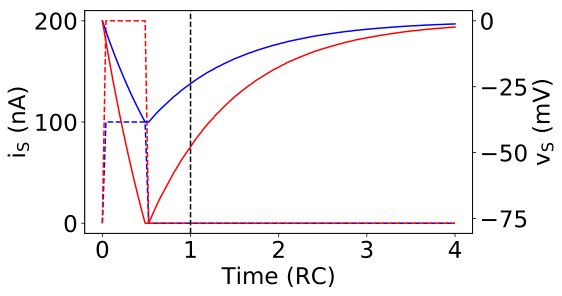

In [35]:
def i_S(t):
    t_off = np.argwhere(np.logical_or(t>i_S.t1, t<=i_S.t0))
    t_on = np.argwhere(np.logical_and(t<=i_S.t1, t>i_S.t0))
    i = np.zeros_like(t)
    i[t_on] = i_S.val #i_S.tramp*t[t_pos]
    
    return i


R_F = 1.0*MOhm
C_INT = 1.0*nF
rc_delay = R_F*C_INT

i_S.val = 100.0*nA
i_S.t0 = 0.0
i_S.t1 = 0.5*rc_delay
i_S.tramp = 0.1*mA/mus

def v_S(tau_int, RF=R_F, CINT=C_INT, v0=0.0*Volt):
    
    v = np.zeros_like(tau_int)
    for j, tau in enumerate(tau_int):
        t = np.linspace(0,tau, 500)
        i = i_S(t)
        f = np.exp((t-tau)/RF/CINT)*RF*i
        I = np.trapz(f,x=t)
        v[j] = v0 - I/RF/CINT
        
    return v


t = np.linspace(0, 4.0*rc_delay,100)

pb.plot(t/rc_delay, i_S(t)/nA, ls='--', c='b')
ax1 = pb.gca()
ax2 = pb.twinx(ax1)
tau_int = np.linspace(0.0, 4.0*rc_delay, 100)
pb.plot(tau_int/rc_delay, v_S(tau_int)/mV, c='b')
i_S.val = 200.0*nA
i_S.tramp = 0.2*mA/mus
ax1.plot(t/rc_delay, i_S(t)/nA, ls='--', c='r')
ax2.plot(tau_int/rc_delay, v_S(tau_int)/mV, c='r')
ax2.axvline(rc_delay/rc_delay, c='k', ls='--')

ax1.set_xlabel('Time ($RC$)')
ax1.set_ylabel('$i_S$ ($nA$)')
ax2.set_ylabel('$v_S$ ($mV$)')
ax2.set_yscale('linear')

In [ ]:
np.trapz?